In [42]:
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
from crop_img import get_bands_arr
from PIL import Image
import numpy as np

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [4]:
classify_model = tf.keras.models.load_model('./sequential_9982')
unet_model = tf.keras.models.load_model('./unet_resnet34_B12_B11_B8A.h5', custom_objects={'binary_crossentropy_plus_jaccard_loss':bce_jaccard_loss, 'iou_score':iou_score})

2022-12-01 12:36:59.422387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-01 12:36:59.422442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: navroop-hp-laptop
2022-12-01 12:36:59.422456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: navroop-hp-laptop
2022-12-01 12:36:59.422545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2022-12-01 12:36:59.422590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2022-12-01 12:36:59.422602: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2022-12-01 12:36:59.422955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is opti

In [43]:
tile = 'L1C_T56HKJ_A023050_20191121T000241'
tile_no = 6

In [44]:
bands = ['B3', 'B4', 'B8', 'B8A', 'B11', 'B12']
unet_bands = ['B12', 'B11', 'B8A']

In [45]:
arr = get_bands_arr(tile, tile_no, bands, 9, (2700,2700))
unet_arr = get_bands_arr(tile, tile_no, unet_bands, 9, (256*9, 256*9))

In [46]:
pred = classify_model.predict(arr)

3/3 [==============================] - 1s 224ms/step


In [47]:
predictions = pred.argmax(axis=1)

In [48]:
predictions = predictions.reshape(9,9)

In [49]:
pred_image = Image.new('RGB', (2700, 2700), color='black')

In [50]:
from keras.utils.np_utils import to_categorical   

In [53]:
unet_input = []
for i in range(9):
    for j in range(9):
        box = (i*300, j*300, i*300+300, j*300+300)
        if predictions[i,j] == 1:
            pred_image.paste('#00ff00', box)
        elif predictions[i,j] == 0:
            pred_image.paste('red', box)
        else:
            unet_input.append((i*9+j, box))
            # unet_img = unet_predict(unet_model, unet_arr[i*9+j], (300,300))
            # pred_image.paste(unet_img, box[:2])

In [54]:
unet_input_arr = np.zeros((len(unet_input), 256,256,3))
for i in range(len(unet_input)):
    unet_input_arr[i] = unet_arr[unet_input[i][0]]
unet_input_arr.shape

(54, 256, 256, 3)

In [55]:
unet_prediction = unet_model.predict(unet_input_arr)

2/2 [==============================] - 8s 3s/step


In [56]:
unet_pred = to_categorical((unet_prediction.argmax(
    axis=3)), num_classes=3).astype('uint8') * 255

In [57]:
for i in range(len(unet_input)):
    nparr = unet_pred[i]
    unknown = nparr[:,:,0]
    burned = nparr[:,:,1]
    vegetation = nparr[:,:,2]
    nparr = np.stack([burned, vegetation, unknown], axis=2)
    img = Image.fromarray(nparr)
    pred_image.paste(img.resize((300,300)), unet_input[i][1])

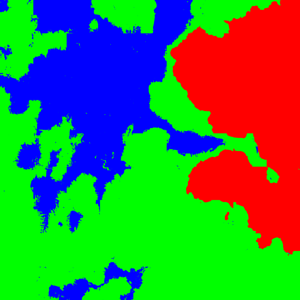

In [58]:
pred_image.resize((300,300))

In [59]:
Image.open(f'./images/{tile}_B12_B11_B8A_{tile_no}.png').resize((300,300))

FileNotFoundError: [Errno 2] No such file or directory: './images/L1C_T56HKJ_A023050_20191121T000241_B12_B11_B8A_6.png'

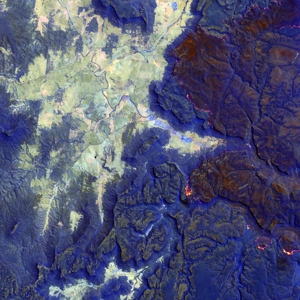

In [ ]:
path = f'./cropped/atm_penetration/{tile}_B12_B11_B8A_{tile_no}.png'
Image.open(path).resize((300,300))

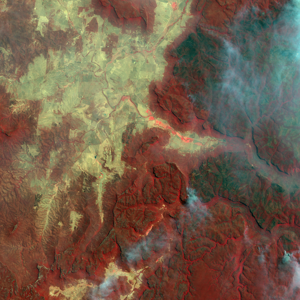

In [ ]:
path = f'../cropped/infrared/{tile}_B8_B4_B3_{tile_no}.png'
Image.open(path).resize((300,300))